# 23、使用SVM进行乳腺癌的检测

**回顾：** SVM是有监督的学习模型，我们需要实现对数据打上分类标签，通过求解最大分类间隔来求解二分类问题。如果要求解多分类问题，可以将二分类器组合起来形成一个多分类器。

着重理解：硬间隔、软间隔、非线性SVM以及分类间隔的公式的应用。

## 如何在sklearn中使用SVM

在Python中的sklearn工具包中有SVM算法，首先需要引入工具包：

In [ ]:
from sklearn import svm

SVM即可以做回归，也可以做分类器。

当用SVM做回归的时候，我们可以使用SVR或者LinearSVR。SVR的英文是Support Vector Regression。

当做分类器的时候，我们使用的是SVC或者LinearSVC。SVC的英文是Support Vector Classification。

**两者的区别：**
- 从名字上可以看出LinearSVC是个线性分类器，用于处理线性可分的数据，只能使用线性核函数。有前面学过的知识可以知道，SVM是通过核函数将样本从原始空间映射到一个更加高维的特质空间中，这样就使得样本在新的空间中线性可分。
- 如果是针对非线性的数据，需要用到SVC。在SVC中，我们既可以使用线性核函数（进行线性划分），也能使用高维度的核函数（进行非线性划分）。

如何创建一个SVM分类器？

我们首先使用SVC的构造函数：model=svm.SVC(kernel='rbf',C=1.0,gamma='auto')，这里有三个重要的参数kernel、C和gamma。

kernel代表核函数的选择，它有四种选择，只不过默认是rbf，即高斯核函数。

- 1、linear：线性核函数
- 2、poly：多项式核函数
- 3、rbf：高斯核函数（默认）
- 4、sigmoid：sigmoid核函数

这四种函数代表的是不同的映射方式，那么在实际工作中，日和选择这4种函数呢？
- **线性核函数**：是在数据线性可分的情况下使用的，运行速度快，效果好。不足在于它不能处理线性不可分的数据。
- **多项式核函数**：可以将数据从低维度空间映射到高维度空间，但是参数比较多，计算量大。
- **高斯核函数**：同样可以将样本映射到高维度空间，但是相对于多项式的核函数来说所需要的参数比较少，通常性能不错，所以是默认使用的核函数。
- **sigmoid核函数**：应用在深度学习中，经常用在神经网络的映射中。因此当选用sigmoid核函数时候，SVM实现的是多层神经网络。

上面列举的4种核函数中，除了第一种的线性核函数之外，其余单重都可以处理线性不可分的数据。

参数C代表的目标函数的惩罚系数，惩罚系数指的是分错样本时的惩罚程度，默认情况下为1.0。当C越大的时候，分类的准确度越高，但是同样容错率会越低，泛化能力会变差。相反，C越小，泛化能力就越强，但是分类的准确性会降低。

参数gamma代表的核函数的系数，默认为样本特征的倒数，即gamma = 1 / n_features.

在创建SVM分类器之后，就可以输入训练集对它进行训练。我们用model.fit(train_X, train_y),传入训练集中的特征矩阵train_X和分类标识train_y.特征值矩阵就是我们在特征选择后抽取的特征值矩阵（当然也可以用全部的数据作为特征值矩阵）；**分类标识就是人工事先针对每个样本标识的分类结果**。这样模型会自动进行分类器的训练。我们可以使用prediction=model.predict(test_X)来对结果进行预测，传入的测试集中的样本特征矩阵test_X,可以得到测试集的预测分类结果prediction。

同样我们也可以创建SVM分类器，使用model= svm.LinearSVC().在LinearSVC中没有kernel这个参数，限制我们只能使用相信核函数。由于LinearSVC对线性分类做了优化，对于数据量大的线性可分问题，使用LinearSVC的效率要高于SVC。

如果不知道数据集是否为线性，可以直接使用SVC类创建SVM分类器。

在训练和预测的过程中，LinearSVC和SVC一样，都是使用model.fit(train_X,train_y)和model.predict(test_X)。


## 如何使用SVM进行乳腺癌检测

根据SVM的创建和使用方法，现在开始进行实际项目的操作：

**材料**
- 数据集：美国威斯康星州的乳腺癌诊断数据集
- 数据部分数据读取可以看下面：
- 数据表参数的32个字段所代表的涵义如下：

In [2]:
import pandas as pd

train_data = pd.read_csv("./data.csv")
# print(train_data.info())
print(train_data.head(5))


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

**32个字段的含义如下：**

|字段|含义|
|--|--|
|ID | ID标识|
|diagnosis| M/B(M:恶性，B：良性) |
|radius_mean | 半径（点中心到边缘的距离）平均值|
|texture_mean |文理（灰度值的标准差）平均值|
|perimeter_mean | 周长 平均值|
|area_mean | 面积  平均值|
|smoothness_mean | 平滑程度（半径内的局部变化） 平均值|
|compactness_mean | 紧密度（=周长*周长/面积-1.0）  平均值|
|concavity_mean | 凹度 （轮廓凹部的严重程度） 平均值|
|concave points_mean|  凹缝（轮廓的凹部分） 平均值|
|symmetry_mean|  对称性 平均值|
|fractal_dimension_mean | 分形维数（=海岸线近似-1） 平均值|
|radius_se|  半径（点中心到边缘的距离） 标准差|
|texture_se | 文理（灰度值的标准差） 标准差|
|perimeter_se | 周长 标准差|
|area_se| 面积 标准差
|smoothness_se | 平滑程度（半径内的局部变化） 标准差|
|compactness_se| 紧密度 （=周长*周长/面积-1.0） 标准差|
|concavity_se | 凹度 （轮廓凹部的严重程度） 标准差|
|concave points_se|  凹缝（轮廓的凹部分） 标准差|
|symmetry_se | 对称性 标准差|
|fractal_dimension_se|  分形维数（=海岸线近似-1） 标准差|
|radius_worst | 半径（点中心到边缘的距离） 最大值|
|texture_worst | 文理（灰度值的标准差） 最大值|
|perimeter_worst | 周长 最大值|
|area_worst |面积 最大值|
|smoothness_worst|  平滑程度（半径内的局部变化） 最大值|
|compactness_worst| 紧密度 （=周长*周长/面积-1.0） 最大值|
|concavity_worst | 凹度 （轮廓凹部的严重程度） 最大值|
|concave points_worst | 凹缝（轮廓的凹部分） 最大值|
|symmetry_worst|  对称性 最大值|
|fractal_dimension_worst | 分形维数（=海岸线近似-1） 最大值|

上面的表格中，mean代表的是平均值，se代表的是标准差，worst代表最大值（3个最大的平均值）。每张图像都计算了相应的特征，得出了这三十个特征值（不包括ID字段和分类标识结果字段diagnosis），实际上是10个特征值（radius、texture、perimeter、area、smoothness、compactness、concavity、concave points、symmetry和fractal_dimension_mean）的3个维度，平均、标准差和最大值。这些特征值都保留了4个数字。字段中没有缺失的值。在569个患者中，一共有357个是良性，212个是恶性。

**目标：**生成一个乳腺癌诊断的SVM分类器，并计算这个分类器的准确率。首先设定项目的执行流程：
- 1、数据获取====>
- 2、准备阶段：数据探索===>数据清洗====>特征选择
- 3、分类阶段：模型训练====>模型评估
![](乳腺癌分析流程.png)

1、首先我们需要加载数据源；
2、在准备阶段，需要对加载的数据源进行探索，查看样本的特征和特征值，这个过程你也可以使用数据可视化，它可以方便我们对数据以及数据之间的关系进一步加深理解。然后按照“完全合一”的标准来评估数据的质量，如果数据质量不高就需要做数据清洗。数据清洗之后，再做特征选择，方便面后续的模型训练；
3、在分类阶段，选择核函数进行训练，如果不知道数据是否为线性，可以考虑使用SVC(kernel="rbf"),也就是高斯函数的SVM分类器。然后对训练好的模型用测试集进行评估

首先加载数据并对数据进行探索：

In [4]:
import pandas as pd

# 加载数据集，需要把数据放到目录中
train_data = pd.read_csv("./data.csv")
# 数据探索
# 因为数据集中列比较多，我们需要把DataFrame中的列全部显示出来
pd.set_option("display.max_columns",None)
print(train_data.columns)
print(train_data.head(5))
print(train_data.describe())

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42

接下来，对数据进行清洗：

从上面运行的结果中，可以看到32个字段里面，id是没有实际的涵义的，可以去掉，diagnosis字段的取值为B或者M，我们可以使用0和1来代替。另外其余的30个字段，其实可以分成三组字段，下划线后面的mean、se和worst代表了每组字段不同的度量方式，分别是平均值、标准差和最大值。

In [ ]:
# 将特征字段分成3组
features_mean= list(data.columns[2:12])
features_se= list(data.columns[12:22])
features_worst= list(data.columns[22:32])
# 数据清洗
# ID列没有用，删除该列
data.drop("id", axis=1,inplace=True)
# 将 B 良性替换成为 0，M 恶性替换成为 1
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})

然后我们要做特征字段的筛选，首先要观察下features_mean各个变量之间的关系，这里我们可以使用DataFrame的corr()函数，然后通过热力图帮助我们可视化呈现。同时，饿哦恩也可以看到整体的良性、恶性肿瘤的诊断情况。

In [ ]:
# 将肿瘤诊断结果可视化
sns.countplot(data['diagnosis'],label="Count")
plt.show()
# 使用热力图呈现features_mean 字段之间的相关性
corr = data[features_mean].corr()
plt.figure(figsize=(14,14))
# annot = True 显示每个方格的数据
sns.heatmap(corr,annot=True)
plt.show()

整合上面的代码如下：

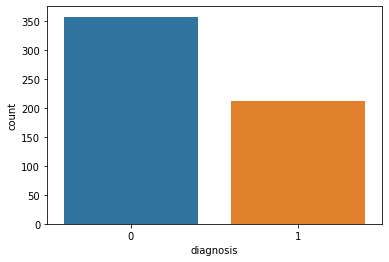

<Figure size 1008x1008 with 0 Axes>

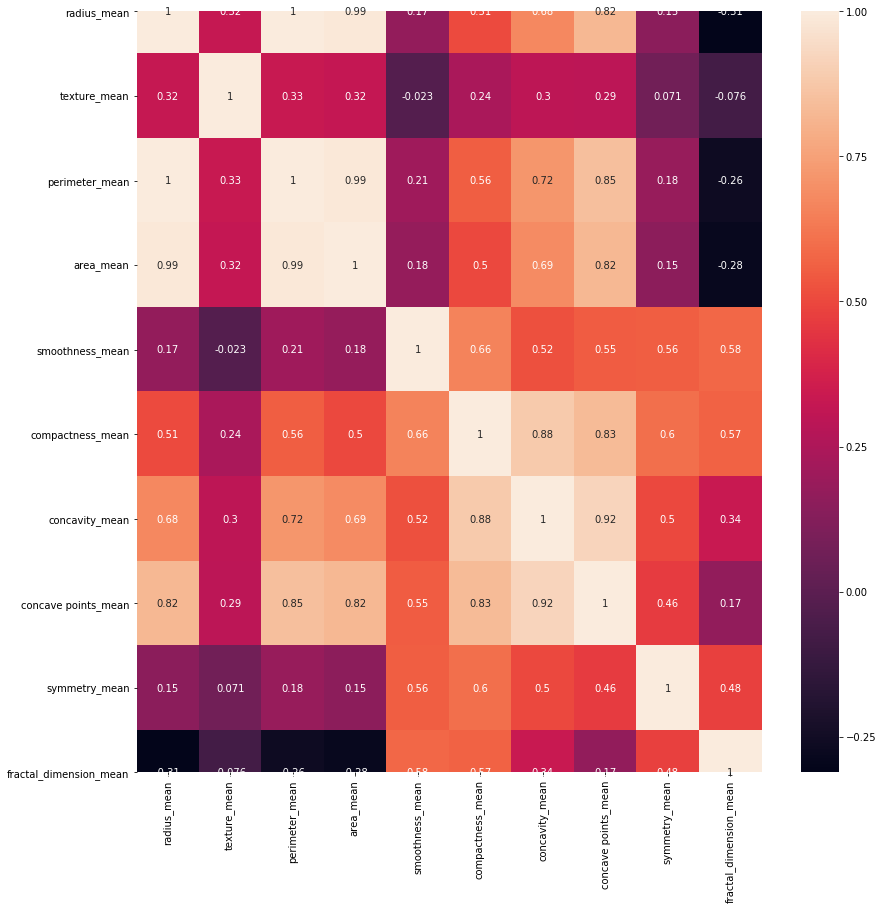

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 加载数据集，需要把数据放到目录中
train_data = pd.read_csv("./data.csv")

# 将特征字段分成3组
features_mean= list(train_data.columns[2:12])
features_se= list(train_data.columns[12:22])
features_worst= list(train_data.columns[22:32])
# 数据清洗
# ID列没有用，删除该列
train_data.drop("id", axis=1,inplace=True)
# 将 B 良性替换成为 0，M 恶性替换成为 1
train_data['diagnosis'] = train_data['diagnosis'].map({'M':1,'B':0})

# 将肿瘤诊断结果可视化,计算出良性和恶性的样本个数并显示出来。
sns.countplot(train_data['diagnosis'],label="Count")
plt.show()

# 使用热力图呈现features_mean 字段之间的相关性
corr = train_data[features_mean].corr()
plt.figure(figsize=(14,14))
# annot = True 显示每个方格的数据
sns.heatmap(corr,annot=True)
plt.show()

热力图中对角线上的为单变量子上的相关系数是1.颜色越浅代表相关性越大。所以你能看出radius_mean、perimeter_mean和area_mean的相关性非常大，从，compactness_mean、concavity_mean、concave_points_mean这三个字段也是相关的，因此我们可以选取其中的一个为代表。

那么如何进行特征选择呢？

特征选择的目的是降维，用少量的特征代表数据的特征，这样也可以增强分类器的泛化能力，避免数据的过拟合。

我们能够看到mean、se和worst这三组特征是对同一组内容的不同的度量方式，可以保留mean这组特征，在特征选择中忽略掉se和worst。同时我们能够看到mean这组特征中，radius_mean、perimeter_mean、area_mean这三个属性相关性大，compactness_mean、daconcavity_mean、concave points_mean这三个属性相关性大。因此可以从这两类中选择1个属性作为代表，比如radius_mean和compactness_mean.（相关的取一个就行，多的不要，不是很相关的要全部带上）

因此，就可以把原来的10个属性缩减为6个属性，代码如下：

In [ ]:
# 特征选择
features_remain = ['radius_mean','texture_mean','smoothness_mean','compactness_mean','symmetry_mean','fractal_dimension_mean']

对特征进行选择之后，我们就可以准备训练集和测试集：

In [ ]:
# 抽取30%的数据作为测试集，其余的作为训练集
train,test = train_test_split(data, test_size = 0.3) # in this out main data is splited into train and test 
# 抽取特征选择的数据作为训练和测试的数据
train_X = train[features_remain]
train_y = train['diagnosis']
test_X = test[features_remain]
test_y = test['diagnosis']

在训练之前，我们需要对数据进行规范化，这样让数据同在一个数量及上，避免因为维度问题造成数据误差：

In [ ]:
# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandarScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

最后我们可以让SVM做训练和预测了：

In [ ]:
# 创建SVM分类器
model = svm.SVC()
# 用训练集做训练
model.fit(train_X, train_y)
# 用测试集做预测
prediction = model.predict(test_X)
print('准确率：',metrics.accuracy_score(prediction,test_y))

代码整合如下所示：

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42

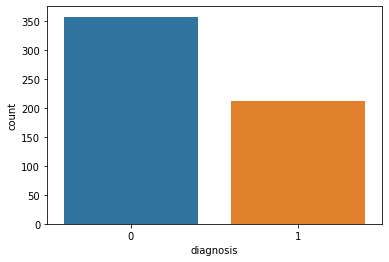

<Figure size 1008x1008 with 0 Axes>

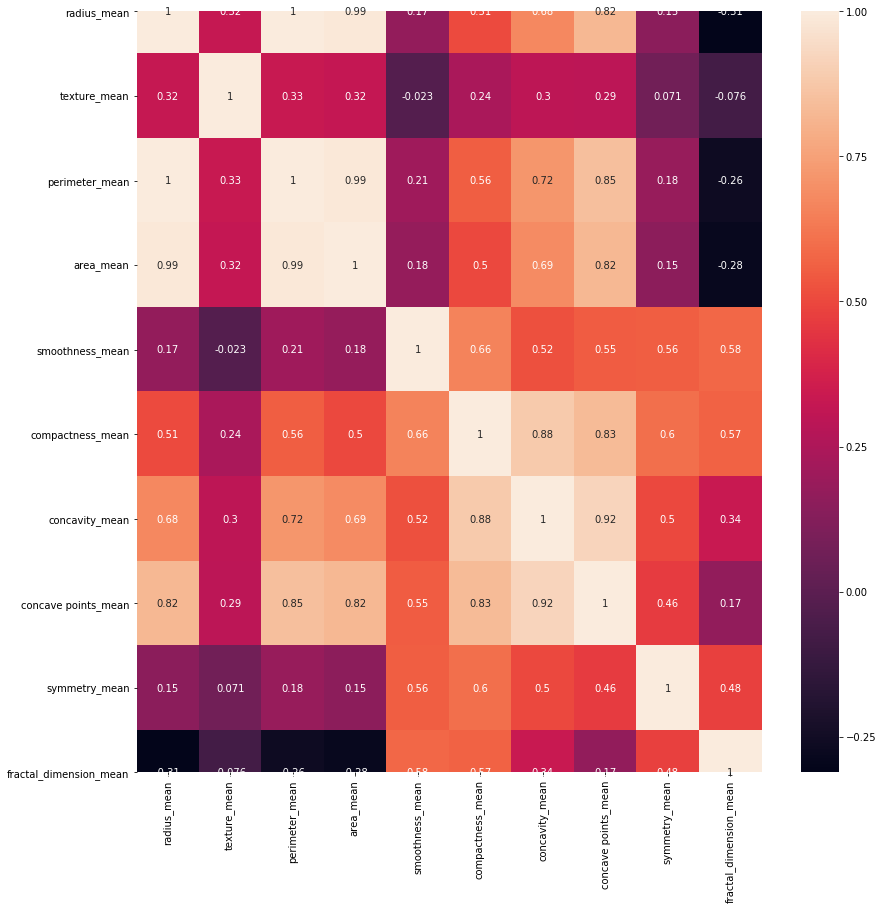

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

默认SVC训练模型测试集准确率（6特征变量）： 0.9181286549707602


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

默认SVC训练模型测试集准确率（10特征变量）： 0.9590643274853801


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
# 导入Z-Score数据变换
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# 导入数据划分
from sklearn.model_selection import train_test_split


# 加载数据集，需要把数据放到目录中
train_data = pd.read_csv("./data.csv")
# 数据探索
# 因为数据集中列比较多，我们需要把DataFrame中的列全部显示出来
pd.set_option("display.max_columns",None)
print(train_data.columns)
print(train_data.head(5))
print(train_data.describe())

# 将特征字段分成3组
features_mean= list(train_data.columns[2:12])
features_se= list(train_data.columns[12:22])
features_worst= list(train_data.columns[22:32])
# 数据清洗
# ID列没有用，删除该列
train_data.drop("id", axis=1,inplace=True)
# 将 B 良性替换成为 0，M 恶性替换成为 1
train_data['diagnosis'] = train_data['diagnosis'].map({'M':1,'B':0})

# 将肿瘤诊断结果可视化,计算出良性和恶性的样本个数并显示出来。
sns.countplot(train_data['diagnosis'],label="Count")
plt.show()

# 使用热力图呈现features_mean 字段之间的相关性
corr = train_data[features_mean].corr()
plt.figure(figsize=(14,14))
# annot = True 显示每个方格的数据
sns.heatmap(corr,annot=True)
plt.show()

# 特征选择
features_remain = ['radius_mean','texture_mean','smoothness_mean','compactness_mean','symmetry_mean','fractal_dimension_mean']

# 抽取30%的数据作为测试集，其余的作为训练集
train,test = train_test_split(data, test_size = 0.3) # in this out main data is splited into train and test 
# 抽取特征选择的数据作为训练和测试的数据
train_X = train[features_remain]
train_y = train['diagnosis']
test_X = test[features_remain]
test_y = test['diagnosis']

# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

# 创建SVM分类器
model = svm.SVC()
# 用训练集做训练
model.fit(train_X, train_y)
# 用测试集做预测
prediction = model.predict(test_X)
print('默认SVC训练模型测试集准确率（6特征变量）：',metrics.accuracy_score(prediction,test_y))

# =============================================（10特征值）=======================
# 特征选择
features_remain1 = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']

# 抽取30%的数据作为测试集，其余的作为训练集
train,test = train_test_split(data, test_size = 0.3) # in this out main data is splited into train and test 
# 抽取特征选择的数据作为训练和测试的数据
train_X = train[features_remain1]
train_y = train['diagnosis']
test_X = test[features_remain1]
test_y = test['diagnosis']

# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

# 创建SVM分类器
model = svm.SVC()
# 用训练集做训练
model.fit(train_X, train_y)
# 用测试集做预测
prediction = model.predict(test_X)
print('默认SVC训练模型测试集准确率（10特征变量）：',metrics.accuracy_score(prediction,test_y))

更改模型使用LinearSVC模型：同时换成10个特征变量：
```py
# 因为第一列的ID已经去掉，所以诊断信息diagnosis为第0列，所以从第1到31，也就是选出第1到30列的数据
features_remain = data.columns[1:31]
```

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42

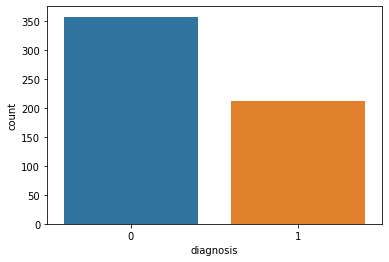

<Figure size 1008x1008 with 0 Axes>

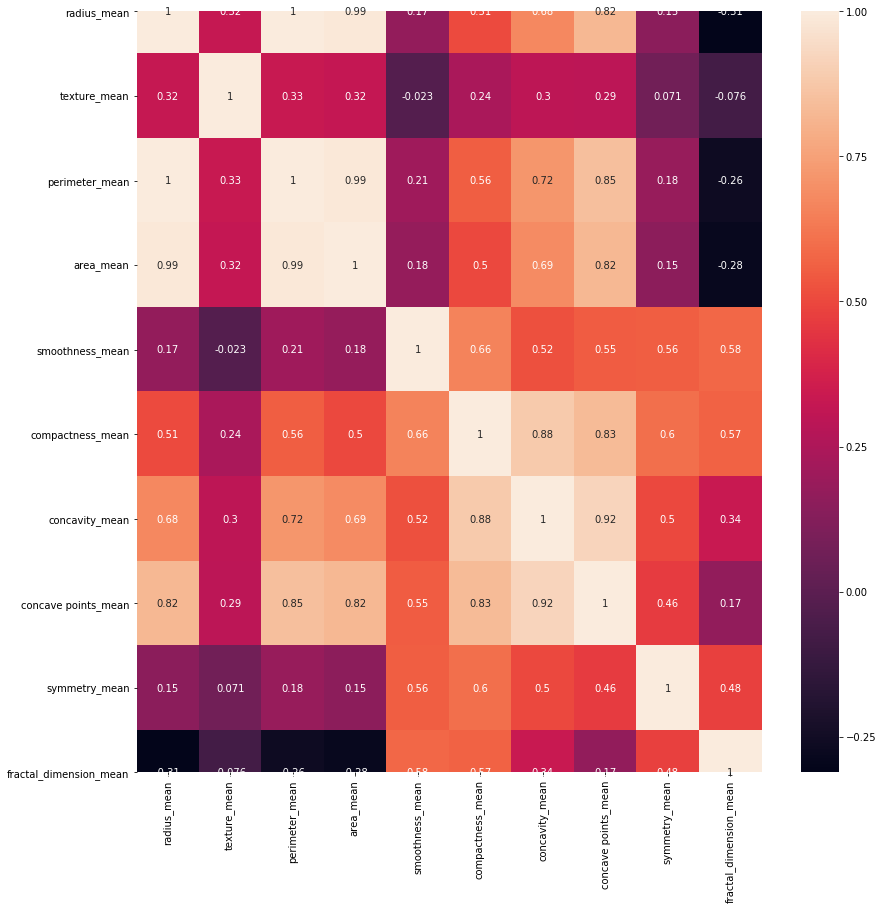

'\nradius_mean\t半径（点中心到边缘的距离）平均值\ntexture_mean\t文理（灰度值的标准差）平均值\nperimeter_mean\t周长 平均值\narea_mean\t面积 平均值\nsmoothness_mean\t平滑程度（半径内的局部变化） 平均值\ncompactness_mean\t紧密度（=周长*周长/面积-1.0） 平均值\nconcavity_mean\t凹度 （轮廓凹部的严重程度） 平均值\nconcave points_mean\t凹缝（轮廓的凹部分） 平均值\nsymmetry_mean\t对称性 平均值\nfractal_dimension_mean\n'

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

LinearSVC训练模型准确率（10特征变量）： 0.9590643274853801


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

LinearSVC训练模型准确率（6特征变量）： 0.9005847953216374


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
# 导入Z-Score数据变换
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# 导入数据划分
from sklearn.model_selection import train_test_split


# 加载数据集，需要把数据放到目录中
train_data = pd.read_csv("./data.csv")
# 数据探索
# 因为数据集中列比较多，我们需要把DataFrame中的列全部显示出来
pd.set_option("display.max_columns",None)
print(train_data.columns)
print(train_data.head(5))
print(train_data.describe())

# 将特征字段分成3组
features_mean= list(train_data.columns[2:12])
features_se= list(train_data.columns[12:22])
features_worst= list(train_data.columns[22:32])
# 数据清洗
# ID列没有用，删除该列
train_data.drop("id", axis=1,inplace=True)
# 将 B 良性替换成为 0，M 恶性替换成为 1
train_data['diagnosis'] = train_data['diagnosis'].map({'M':1,'B':0})

# 将肿瘤诊断结果可视化,计算出良性和恶性的样本个数并显示出来。
sns.countplot(train_data['diagnosis'],label="Count")
plt.show()

# 使用热力图呈现features_mean 字段之间的相关性
corr = train_data[features_mean].corr()
plt.figure(figsize=(14,14))
# annot = True 显示每个方格的数据
sns.heatmap(corr,annot=True)
plt.show()

'''
radius_mean	半径（点中心到边缘的距离）平均值
texture_mean	文理（灰度值的标准差）平均值
perimeter_mean	周长 平均值
area_mean	面积 平均值
smoothness_mean	平滑程度（半径内的局部变化） 平均值
compactness_mean	紧密度（=周长*周长/面积-1.0） 平均值
concavity_mean	凹度 （轮廓凹部的严重程度） 平均值
concave points_mean	凹缝（轮廓的凹部分） 平均值
symmetry_mean	对称性 平均值
fractal_dimension_mean
'''

# 特征选择
features_remain = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean']

# 抽取30%的数据作为测试集，其余的作为训练集
train,test = train_test_split(data, test_size = 0.3) # in this out main data is splited into train and test 
# 抽取特征选择的数据作为训练和测试的数据
train_X = train[features_remain]
train_y = train['diagnosis']
test_X = test[features_remain]
test_y = test['diagnosis']

# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

# 创建SVM分类器
model = svm.LinearSVC()
# 用训练集做训练
model.fit(train_X, train_y)
# 用测试集做预测
prediction = model.predict(test_X)
print('LinearSVC训练模型准确率（10特征变量）：',metrics.accuracy_score(prediction,test_y))

# ===================================（6特征变量）===========================
# 特征选择
features_remain = ['radius_mean','texture_mean','smoothness_mean','compactness_mean','symmetry_mean','fractal_dimension_mean']

# 抽取30%的数据作为测试集，其余的作为训练集
train,test = train_test_split(data, test_size = 0.3) # in this out main data is splited into train and test 
# 抽取特征选择的数据作为训练和测试的数据
train_X = train[features_remain]
train_y = train['diagnosis']
test_X = test[features_remain]
test_y = test['diagnosis']

# 采用Z-Score规范化数据，保证每个特征维度的数据均值为0，方差为1
ss = StandardScaler()
train_X = ss.fit_transform(train_X)
test_X = ss.transform(test_X)

# 创建SVM分类器
model = svm.LinearSVC()
# 用训练集做训练
model.fit(train_X, train_y)
# 用测试集做预测
prediction = model.predict(test_X)
print('LinearSVC训练模型准确率（6特征变量）：',metrics.accuracy_score(prediction,test_y))

## 总结

SVM分类算法进行的乳腺癌诊断分类实战过程中的流程：
- 数据加载==>数据探索==>数据清洗==>特征选择==>SVM训练==>结果评估

sklearn已经为我们提供了很好的工具，对于SVM的创建和封装都进行了封装，我们在理解算法过程的基础上无需关心中间的运算细节。但是正是因为如此，我们更加需要对每一个流程熟练掌握，提升训练数据化思维和对数据的敏感度。

**SVM实战**
- 数据集
    - 威斯康星州的乳腺癌诊断数据集
    - 32个字段包括3组特征（mean、se、wworst）
- sklearn使用
    - SVM分类
        - SVC：默认是高斯核函数，即kernel=rbf
        - LinearSVC：线性SVC，没有kernel参数，只能是线性核函数
    - SVM回归
        - SCR和LinearSVR
- 项目流程
    - 准备阶段：数据探索、数据可视化、数据清洗
    - 分类阶段：特征选择、模型训练、模型估计
    
**作业总结**
- 1、增加特征变量可以提高准确率，存在过拟合的现象，泛化能力弱，模型变得更加复杂可以看出特征变量的选取很重要。
- 2、特征选择、以及数据的处理都很重要。选择不同的特征，有时候比选择不同的分类算法重要。
- 3、关于数据的规范化：有提供的数据集可以知道，数据集的数据是跨度很大的，所以需要规范化。当我们在做数据挖掘之前，不同的指标可能会有不同的量纲，如果我们不消除这些指标之间的取值范围的差别，以及不同的量纲所造成的影响的话，就会影响到后续的数据分析（分类、聚类）的结果。因此我们需要进行规范化处理，也就是让数据按照一定的标准落到一个特定的区间内，便于我们的后续分析使用。同时，在处理的时候训练集和测试集都需要进行数据的规范化，其实在代码上面实现并不麻烦，而且这是数据挖掘前的一项基础工作。